In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [30]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2011
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [31]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

data compromises 11 years: 2637 lines


In [32]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [33]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
    # 'vixo_lag1',
    #  'vixo_lag2',
    #  'vixo_lag3',
    #  'vixo_lag4',
    #  'vixo_lag5',
    #  'vixo_lag6',
    #  'vixo_lag7',
    #  'vixo_lag8',
    #  'vixo_lag9',
    #  'vixo_lag10',
    #  'vixo_lag11',
    #  'vixo_lag12',
    #  'vixo_lag13',
    #  'vixo_lag14',
    #  'vixo_lag15',
    #  'vixo_lag16',
    #  'vixo_lag17',
    #  'vixo_lag18',
    #  'vixo_lag19',
    #  'vixo_lag20',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     # 'ff_M_RF_lag1',
     # 'ff_M_RF_lag2',
     # 'ff_M_RF_lag3',
     # 'ff_M_RF_lag4',
     # 'ff_M_RF_lag5',
     # 'ff_M_RF_lag6',
     # 'ff_M_RF_lag7',
     # 'ff_M_RF_lag8',
     # 'ff_M_RF_lag9',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     'sp_close_lag10',
     'sp_close_lag11',
     'sp_close_lag12',
     'sp_close_lag13',
     'sp_close_lag14',
     'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [34]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [35]:
df_train = df_ws.copy()

In [36]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality


 Len of complete weeks in X_train: 1425


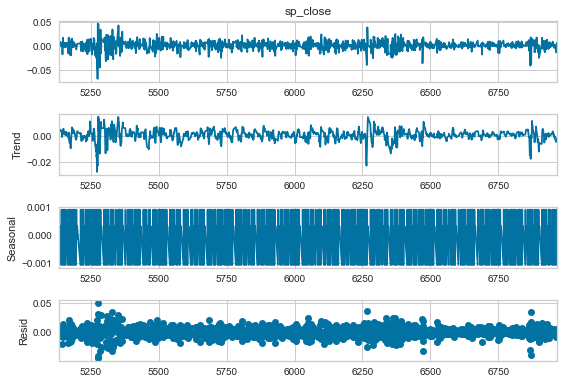

In [37]:
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# create seasonality object
sd = SeasonalTrend(X_train_sea, 'sp_close', 'week', 'weekday', 5, show_fig=True)       
sd.split_time_series()

 # map sesonality to data
if week_day == 'daily': 
    data_dict["model_features"]["weekday_seasonality"] = sd.dict_map_sasonal
    
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [38]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

In [39]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
# X_train = orthogonalise_vars(X_train, X="sp_close_lag1", y="ff_M_RF_lag1", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close_lag4,1.029424,-0.078177
sp_close,1.388069,-0.054191
sp_close_lag2,1.024257,-0.053820
ff_HML,1.565008,-0.053298
seasonal,1.015977,-0.042724
sp_close_lag13,1.031952,-0.037484
sp_close_lag12,1.023824,-0.033157
ff_SMB,1.461078,-0.020041
sp_close_lag8,1.033010,-0.019294
ff_M_RF,1.331020,-0.018454


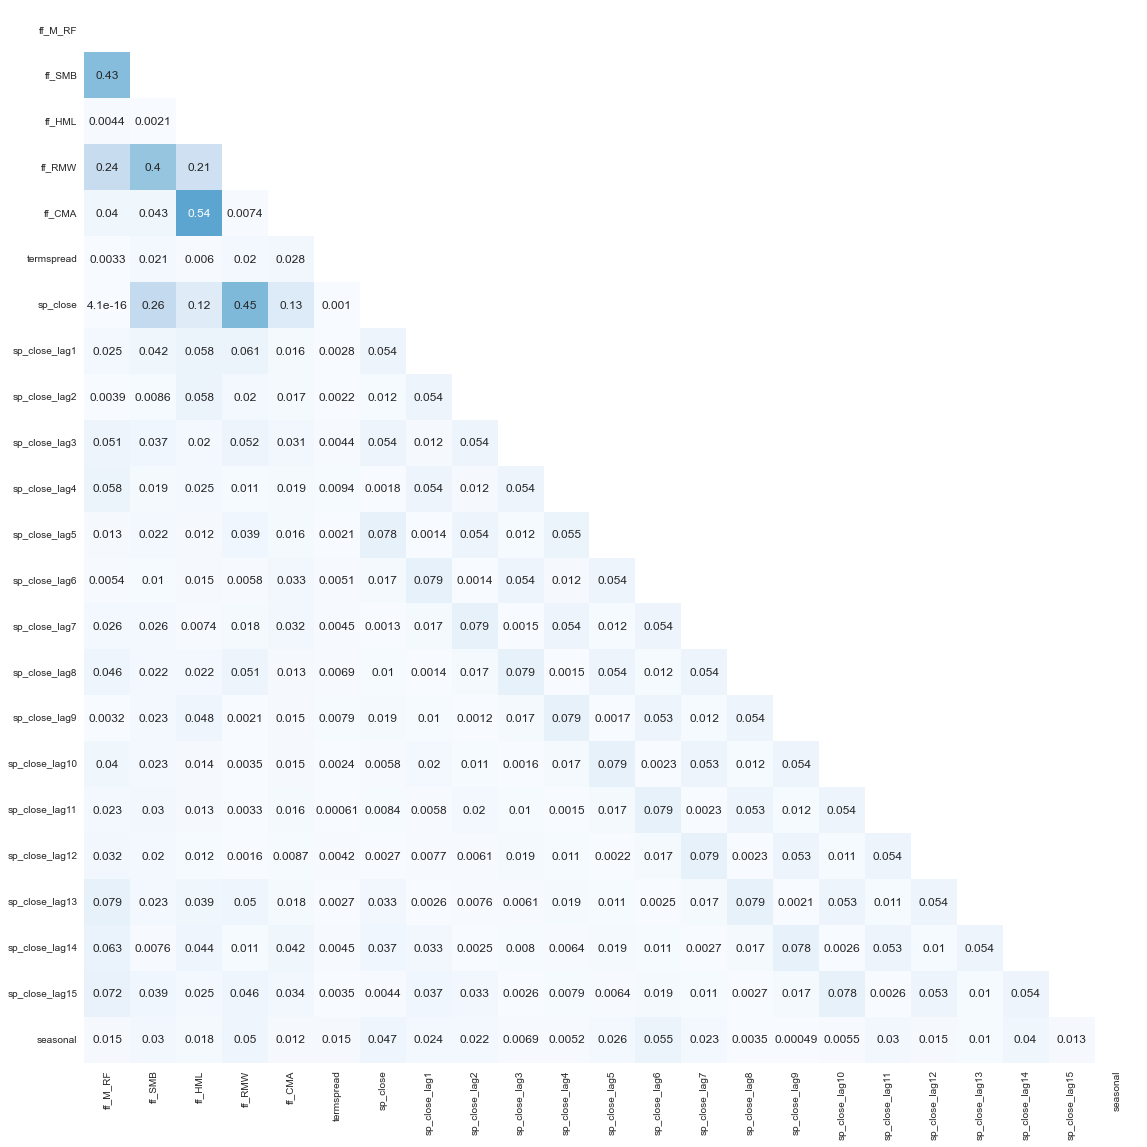

In [40]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             size_factor=.7,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [41]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [42]:
model_wrap = ExpandingPredictionOLS(SKLearnWrap(sm.OLS),
                    X_train,
                    y_train,
                    X_test,
                    y_test)

# Out of sample eval

In [43]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

In [44]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model_wrap,
            print_results=True)

In [45]:
mval.model.model.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     10.25
Date:                Thu, 24 Mar 2022   Prob (F-statistic):           2.12e-35
Time:                        11:00:07   Log-Likelihood:                 8264.7
No. Observations:                2636   AIC:                        -1.648e+04
Df Residuals:                    2612   BIC:                        -1.634e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ff_M_RF           -0.1417      0.038     -3.767      0.000      -0.215      -0.068
ff_SMB             0.1676      0.037      4.469      0.000       0.094       0.241
ff_HML            -0.0578      0.036     -1.608      0.108      -0.128       0.013
ff_RMW             0.0974      0.056      1.736      0.083      -0.013       0.207
ff_CMA            -0.0329      0.075     -0.436      0.663      -0.181       0.115
termspread         0.0004      0.001      0.418      0.676      -0.002       0.002
sp_close          -0.0606      0.027     -2.209      0.027      -0.114      -0.007
sp_close_lag1      0.0706      0.020      3.598      0.000       0.032       0.109
sp_close_lag2     -0.0150      0.020     -0.762      0.446      -0.054       0.024
sp_close_lag3     -0.0358      0.020     -1.817      0.069      -0.074       0.003
sp_close_lag4     -0.0264      0.020     -1.339      0.181      -0.065       0.012
sp_close_lag5     -0.0739      0.020     -3.748      0.000      -0.113      -0.035
sp_close_lag6      0.0883      0.020      4.471      0.000       0.050       0.127
sp_close_lag7     -0.0451      0.020     -2.267      0.023      -0.084      -0.006
sp_close_lag8      0.0516      0.020      2.604      0.009       0.013       0.090
sp_close_lag9      0.0071      0.020      0.356      0.722      -0.032       0.046
sp_close_lag10     0.0091      0.020      0.462      0.644      -0.029       0.048
sp_close_lag11     0.0257      0.020      1.303      0.193      -0.013       0.064
sp_close_lag12    -0.0675      0.020     -3.430      0.001      -0.106      -0.029
sp_close_lag13    -0.0202      0.020     -1.022      0.307      -0.059       0.019
sp_close_lag14     0.0045      0.020      0.229      0.819      -0.034       0.043
sp_close_lag15     0.0221      0.020      1.131      0.258      -0.016       0.060
seasonal          -0.4729      0.331     -1.427      0.154      -1.122       0.177
intercept          0.0001      0.001      0.154      0.877      -0.002       0.002
==============================================================================
Omnibus:                      919.787   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15818.650
Skew:                          -1.193   Prob(JB):                         0.00
Kurtosis:                      14.761   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

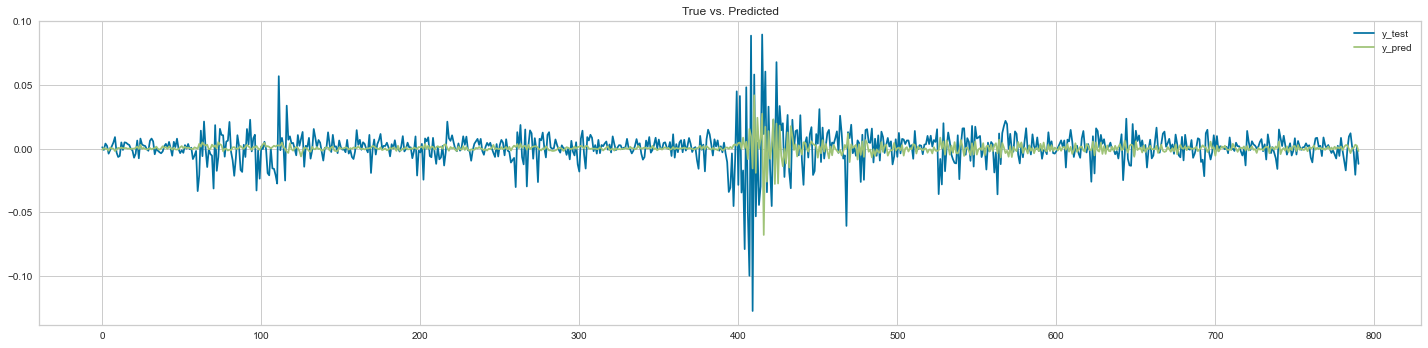

Validation Scores
root mean squared error: 0.0140381748
mean squared error: 0.0001970704
mean absolute error: 0.0086444849
R2: 0.0460401316


In [46]:
fig_true_vs_fit = mval.get_model_performance()

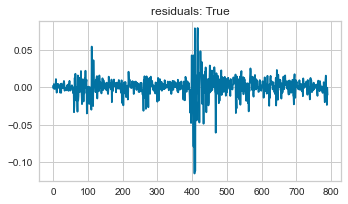

Stationarity Test Results
P-Values: 3.4685073329401004e-12
Test-stats: -7.933204375568554
Time series is stationary: True




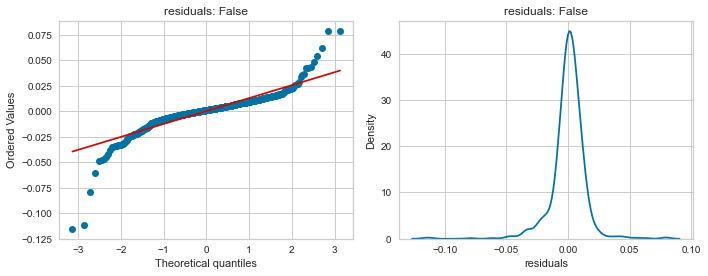

Normality Test Results
P-Values: 3.264975628661581e-74
Test-stats: 338.4160891665621
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


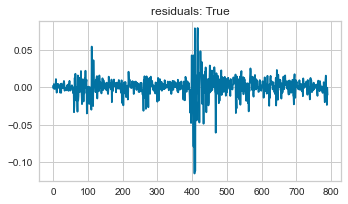

Test for Heteroskedasticity
Test p-value: 3.088502498350728e-41
Heteroskedasticity is present: True


TTest one sample for mean: 0
Test statistics: 0.6072785595273211
Test pvalue: 0.5438405669120141
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.058 < 2.5
First order autocorrlation is not present: : True


In [47]:
stat, norm, hetero, d_watson, zero_mean = mval.analyse_resids()

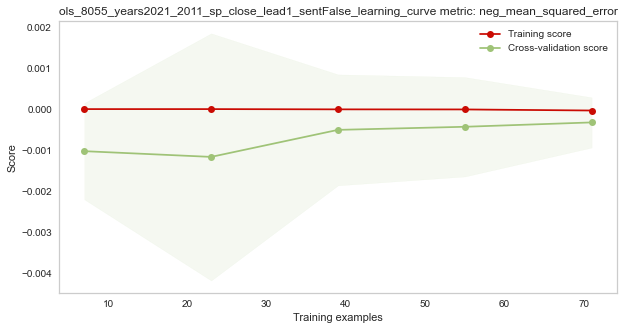

In [48]:
fig_lcurve = mval.learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve")

In [49]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [50]:
save_model(model=mval.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_true_vs_fit,
                        fig_lcurve], 
           fig_titles=['fig_truefit', 
                       'fig_lcurve'],
           model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-24_ols_8055_years2021_2011_sp_close_lead1_sentFalse"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
